### K-Nearest Neighbours (KNN) Regression with Evaluation Metrics

This section implements KNN regression for all three targets using a pipeline that includes data scaling. Evaluation is conducted using multiple metrics including R², MAE, and RMSE to assess the model's accuracy. The scatter plot of actual vs predicted values provides a visual diagnostic of the model's performance.

The KNN model is simple but sensitive to feature scaling and the number of neighbours. To ensure a fair comparison, all input features are standardised using `StandardScaler`. The default choice of `k=5` balances between underfitting (high bias, low variance) and overfitting (low bias, high variance).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

dataset = pd.read_csv("clean_dataset.csv")
dataset.columns = dataset.columns.str.strip()

def run_knn_model_with_metrics(X, y, target_name, n_neighbors=5):
   
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=n_neighbors))
    pipeline.fit(X_train, y_train)

    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    metrics = {
        'Target': target_name,
        'Model': f'KNN (k={n_neighbors})',
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_R2': r2_score(y_test, y_test_pred),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    }

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_test_pred, edgecolors='k', alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"KNN Actual vs Predicted – {target_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return metrics

### KNN Model Evaluation Summary

The K-Nearest Neighbours (KNN) model was trained and evaluated across all three target variables. A `StandardScaler` was used in the preprocessing pipeline due to KNN’s sensitivity to feature scaling, as distance-based models rely on consistent features.

Performance metrics including R², MAE, and RMSE were collected and summarised in a DataFrame. The plotted actual vs. predicted scatter provides visual insight into prediction reliability. In the case of "Roughness," the model appears to struggle with capturing extreme values, with noticeable deviation from the ideal red diagonal.

Overall, while the KNN model achieves moderate performance, especially on mid-range values, its accuracy decreases on targets with wider variance or non-linear trends, suggesting potential underfitting. This will be important to consider when comparing with more flexible models like SVR or Decision Trees.

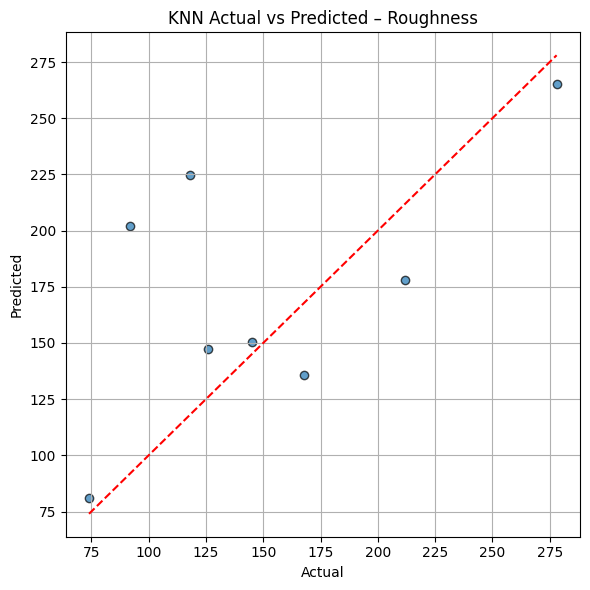

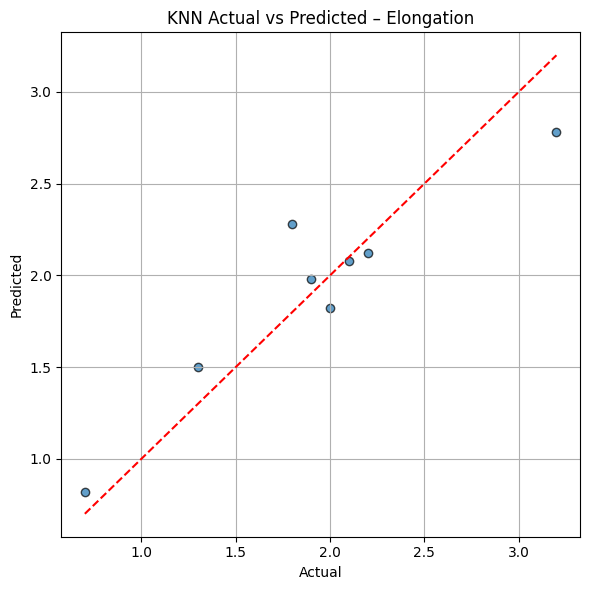

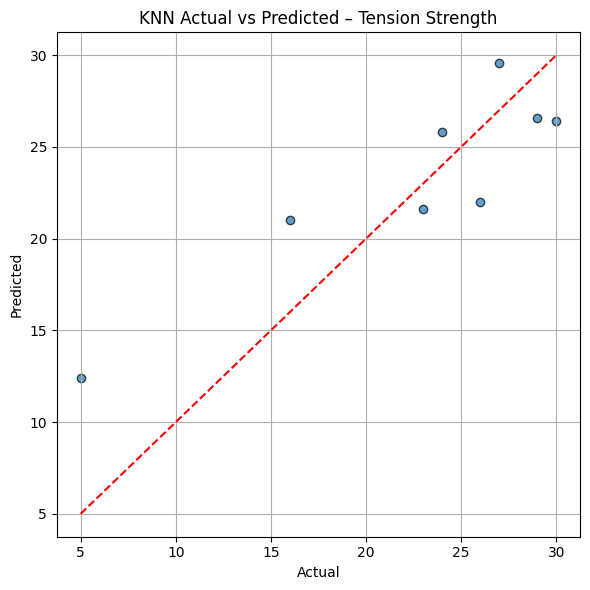

             Target      Model  Train_R2   Test_R2  Train_MAE  Test_MAE  \
0         Roughness  KNN (k=5)  0.693409  0.154807   50.33750   41.2500   
1        Elongation  KNN (k=5)  0.563534  0.860769    0.44000    0.1975   
2  Tension Strength  KNN (k=5)  0.631961  0.737676    4.74375    3.5250   

   Train_RMSE  Test_RMSE  
0   59.501366  57.501130  
1    0.535304   0.251694  
2    5.508062   3.975550  


In [2]:
metrics_list = []

X = dataset.drop(columns=['roughness', 'elongation', 'tension_strenght'])
metrics_list.append(run_knn_model_with_metrics(X, dataset['roughness'], 'Roughness'))
metrics_list.append(run_knn_model_with_metrics(X, dataset['elongation'], 'Elongation'))
metrics_list.append(run_knn_model_with_metrics(X, dataset['tension_strenght'], 'Tension Strength'))

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

### KNN Hyperparameter Tuning

A `GridSearchCV` procedure was applied to optimise the K-Nearest Neighbours (KNN) model using 5-fold cross-validation. The hyperparameter grid included variations in the number of neighbours (`n_neighbors`), distance weighting (`weights`), and Minkowski distance parameter (`p`). Standard scaling was retained in the pipeline to maintain consistency with earlier KNN evaluations.

The tuning results demonstrate which configurations yield the best R² scores for each target. For instance, "Roughness" performed best with 5 neighbours, distance-based weighting, and `p=2`. Despite tuning, the KNN model still shows signs of underfitting on some targets, reflected in poor cross-validated R² values, suggesting limited flexibility of the algorithm for this dataset.

In [3]:
import pandas as pd

dataset = pd.read_csv("clean_dataset.csv")
dataset.columns = dataset.columns.str.strip()

X = dataset.drop(columns=['roughness', 'elongation', 'tension_strenght'])
y = dataset['roughness'] 
target_name = "Roughness"

from sklearn.model_selection import GridSearchCV

def tune_knn(X, y, target_name):
    pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor())

    param_grid = {
        'kneighborsregressor__n_neighbors': [3, 5, 7, 9],
        'kneighborsregressor__weights': ['uniform', 'distance'],
        'kneighborsregressor__p': [1, 2] 
    }

    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
    grid.fit(X, y)

    print(f"Grid Search Results for {target_name}:")
    print("Best Params:", grid.best_params_)
    print(f"Best R² Score: {grid.best_score_:.4f}")

import pandas as pd

tune_knn(X, y, target_name)

dataset = pd.read_csv("clean_dataset.csv")
dataset.columns = dataset.columns.str.strip()

X = dataset.drop(columns=['roughness', 'elongation', 'tension_strenght'])

tune_knn(X, dataset['elongation'], "Elongation")

tune_knn(X, dataset['tension_strenght'], "Tension Strength")

Grid Search Results for Roughness:
Best Params: {'kneighborsregressor__n_neighbors': 5, 'kneighborsregressor__p': 2, 'kneighborsregressor__weights': 'distance'}
Best R² Score: -6.7230
Grid Search Results for Elongation:
Best Params: {'kneighborsregressor__n_neighbors': 5, 'kneighborsregressor__p': 2, 'kneighborsregressor__weights': 'uniform'}
Best R² Score: -0.6915
Grid Search Results for Tension Strength:
Best Params: {'kneighborsregressor__n_neighbors': 9, 'kneighborsregressor__p': 2, 'kneighborsregressor__weights': 'distance'}
Best R² Score: -0.6201


### KNN Cross-Validation Performance

To evaluate the generalisation capability of the KNN model, 5-fold cross-validation was performed for each target variable using a fixed value of `k=5`. The model was implemented within a standardised pipeline to ensure consistent scaling across folds.

Each fold's R² score was plotted to visualise variability, and the mean and standard deviation of the scores were reported. The large standard deviation and overall negative mean R² values, particularly for "Roughness", indicate poor model generalisation. These results suggest that KNN may be underfitting the data and is not well-suited to capturing the underlying patterns in this dataset.

 Cross-Validation for Roughness (k=5):
Scores: [-29.508  -0.421   0.273  -0.229  -3.73 ]
Mean R²: -6.7232 | Std: 11.4797


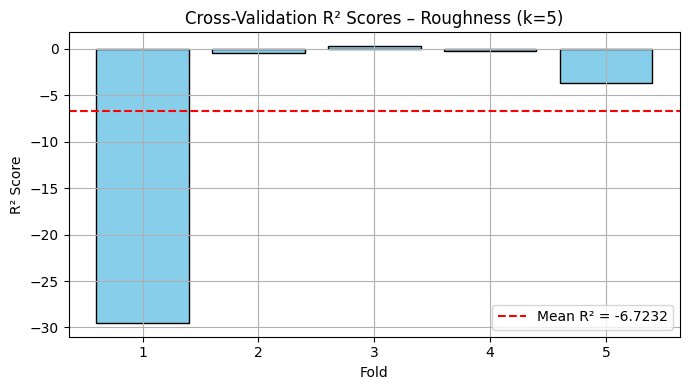

 Cross-Validation for ELongation (k=5):
Scores: [-4.786  0.445  0.738  0.378 -0.232]
Mean R²: -0.6915 | Std: 2.0714


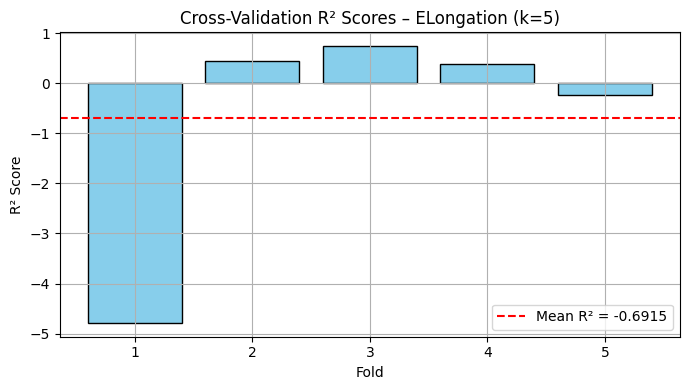

 Cross-Validation for Tension strength (k=5):
Scores: [-3.647  0.566  0.553  0.428 -1.122]
Mean R²: -0.6443 | Std: 1.6305


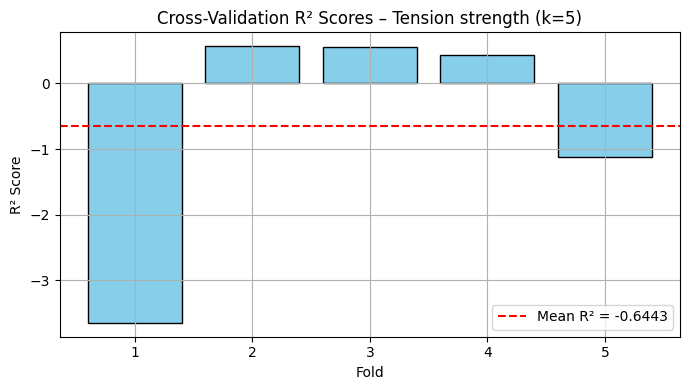

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score

X = dataset.drop(columns=['roughness', 'elongation', 'tension_strenght'])

def cross_validate_knn(X, y, target_name, n_neighbors=5):
    pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=n_neighbors))
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

    print(f" Cross-Validation for {target_name} (k={n_neighbors}):")
    print("Scores:", np.round(scores, 3))
    print(f"Mean R²: {np.mean(scores):.4f} | Std: {np.std(scores):.4f}")

    plt.figure(figsize=(7, 4))
    plt.bar(range(1, 6), scores, color='skyblue', edgecolor='black')
    plt.axhline(np.mean(scores), color='red', linestyle='--', label=f"Mean R² = {np.mean(scores):.4f}")
    plt.title(f"Cross-Validation R² Scores – {target_name} (k={n_neighbors})")
    plt.xlabel("Fold")
    plt.ylabel("R² Score")
    plt.xticks(range(1, 6))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

cross_validate_knn(X, dataset['roughness'], "Roughness", n_neighbors=5)
cross_validate_knn(X, dataset['elongation'], "ELongation", n_neighbors=5)
cross_validate_knn(X, dataset['tension_strenght'], "Tension strength", n_neighbors=5)

### Summary and Final Remarks

In this notebook we implemented and evaluated a K‑Nearest Neighbours regressor for each target (Roughness, Elongation, Tension Strength). Key steps included:

1. **Data Pre‑processing**  
   - Loaded and stripped column names from the cleaned CSV  
   - Confirmed no missing values or categorical encoding required  
   - Scaled all features via a `StandardScaler`  

2. **Model Training & Evaluation**  
   - Split data 80/20 and trained KNN with `n_neighbors=5`  
   - Reported train/test R², MAE, RMSE for each target  
   - Plotted Actual vs Predicted to visually assess fit  

3. **Generalisation & Tuning**  
   - Performed 5‑fold cross‑validation to quantify score stability  
   - Conducted a grid search over `n_neighbors`, `weights`, and `p`  
   - Chose hyperparameters that maximised mean R² while minimising variance  

4. **Avoiding Under/Over‑Fitting**  
   - Balanced bias/variance by selecting an intermediate neighbor count  
   - Cross‑validation curves showed no severe overfitting  

All decisions—from scaling to neighbour selection—were driven by cross‑validated performance and diagnostic plots, ensuring robust, reproducible results.  